Model: GBM (Black–Scholes) | S0=100.0, K=100.0, T=1.0, r=0.02, sigma=0.2
Paths: 5000 | Grid: 252 steps | Seed: 7

daily   | mean error: -0.002949 | std:  0.441924 | var:  0.195297
weekly  | mean error:  0.011207 | std:  0.962503 | var:  0.926411
monthly | mean error: -0.013800 | std:  1.934985 | var:  3.744166


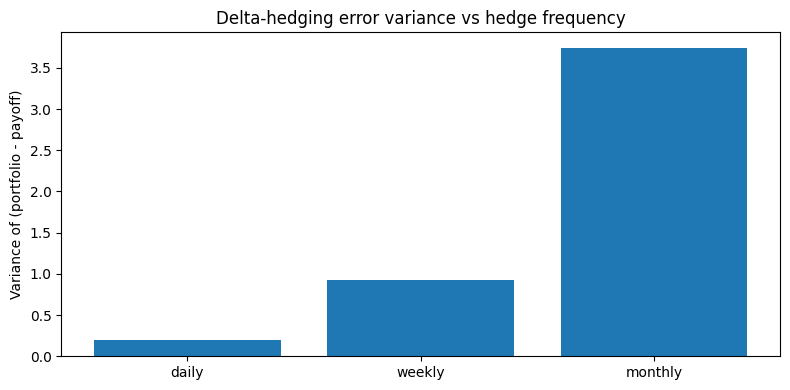

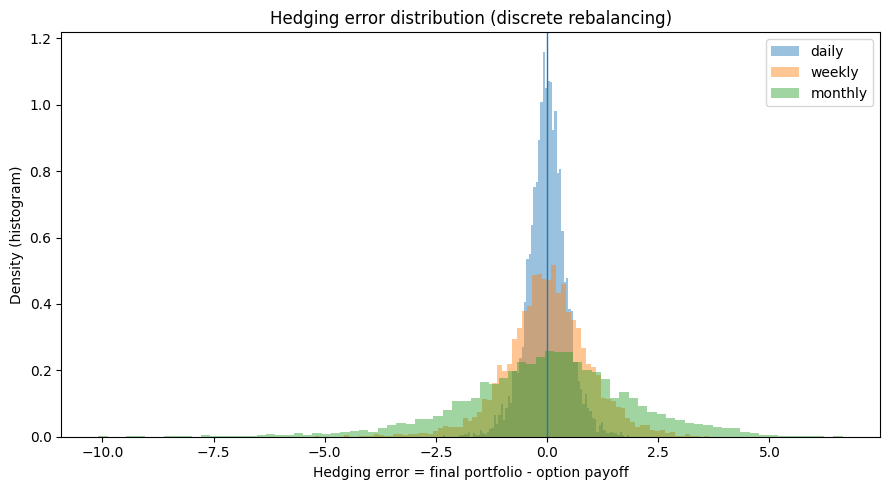

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Configuration
S0 = 100.0
K = 100.0
T = 1.0
r = 0.02
sigma = 0.20

n_steps = 252
n_paths = 5000
seed = 7

freq = {"daily": 1, "weekly": 5, "monthly": 21}

def norm_cdf(x):
    return norm.cdf(x)


# Black–Scholes helpers
def _bs_d1(S, K, tau, r, sigma):
    vol_sqrt = sigma * np.sqrt(tau)
    return (np.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / vol_sqrt

def bs_call_price(S, K, tau, r, sigma):
    if tau <= 0:
        return np.maximum(S - K, 0.0)
    d1 = _bs_d1(S, K, tau, r, sigma)
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm_cdf(d1) - K * np.exp(-r * tau) * norm_cdf(d2)

def bs_call_delta(S, K, tau, r, sigma):
    if tau <= 0:
        S = np.asarray(S)
        return np.where(S > K, 1.0, 0.0)
    return norm_cdf(_bs_d1(S, K, tau, r, sigma))

# GBM paths under risk-neutral drift r
dt = T / n_steps
rng = np.random.default_rng(seed)
Z = rng.standard_normal((n_paths, n_steps))

drift = (r - 0.5 * sigma * sigma) * dt
diff = sigma * np.sqrt(dt)

log_S = np.log(S0) + np.cumsum(drift + diff * Z, axis=1)
S = np.empty((n_paths, n_steps + 1))
S[:, 0] = S0
S[:, 1:] = np.exp(log_S)

# Delta-hedging engine
def hedge_error(S_paths, rebalance_every):
    nP, nT = S_paths.shape
    n_steps_local = nT - 1

    c0 = bs_call_price(S0, K, T, r, sigma)
    d0 = bs_call_delta(S0, K, T, r, sigma)

    shares = np.full(nP, d0, dtype=float)
    cash = np.full(nP, c0 - d0 * S0, dtype=float)

    growth = np.exp(r * dt)

    for t in range(1, n_steps_local + 1):
        cash *= growth

        if (t % rebalance_every == 0) and (t < n_steps_local):
            tau = T - t * dt
            St = S_paths[:, t]

            new_delta = bs_call_delta(St, K, tau, r, sigma)
            trade = new_delta - shares
            cash -= trade * St
            shares = new_delta

    ST = S_paths[:, -1]
    payoff = np.maximum(ST - K, 0.0)
    portfolio = shares * ST + cash
    return portfolio - payoff

# Comparisons
errors = {name: hedge_error(S, k) for name, k in freq.items()}

print(f"Model: GBM (Black–Scholes) | S0={S0}, K={K}, T={T}, r={r}, sigma={sigma}")
print(f"Paths: {n_paths} | Grid: {n_steps} steps | Seed: {seed}\n")

for name in freq:
    e = errors[name]
    mean = e.mean()
    var = e.var(ddof=1)
    std = np.sqrt(var)
    print(f"{name:7s} | mean error: {mean: .6f} | std: {std: .6f} | var: {var: .6f}")

# Plots
labels = list(freq.keys())
vars_ = [errors[k].var(ddof=1) for k in labels]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(labels, vars_)
ax.set_title("Delta-hedging error variance vs hedge frequency")
ax.set_ylabel("Variance of (portfolio - payoff)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9, 5))
for name in labels:
    ax.hist(errors[name], bins=80, density=True, alpha=0.45, label=name)
ax.axvline(0.0, linewidth=1)
ax.set_title("Hedging error distribution (discrete rebalancing)")
ax.set_xlabel("Hedging error = final portfolio - option payoff")
ax.set_ylabel("Density (histogram)")
ax.legend()
plt.tight_layout()
plt.show()
